In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.layers import Input, Conv2D, Dense, Flatten, Conv2DTranspose, Reshape, Lambda
import keras.backend as K
import matplotlib.pyplot as plt

In [16]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [17]:
train_images = np.expand_dims(train_images, axis=-1) / 255
test_images = np.expand_dims(test_images, axis=-1) / 255

In [18]:
latent_dim = 16
input_shape = train_images.shape[1:]

print(f"input shape: {input_shape}")

input shape: (28, 28, 1)


In [19]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [20]:
encoder_input = Input(shape=input_shape)
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_var], name="encoder")
print(encoder.summary())


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [21]:
decoder_input = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(decoder_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(decoder_input, [decoder_output], name="decoder")
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_7 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [22]:
x = Input(shape=input_shape)
z_mean, z_log_var = encoder(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_hat = decoder(z)

vae = keras.Model(x, x_hat, name="vae")
print(vae.summary())

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 16),         69552       ['input_6[0][0]']                
                                 (None, 16)]                                                      
                                                                                                  
 lambda_1 (Lambda)              (None, 16)           0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                                

In [23]:
recon_loss = keras.metrics.binary_crossentropy(K.flatten(x), K.flatten(x_hat))
kl_loss = -5e-4 * K.mean(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(recon_loss + kl_loss)
vae.add_loss(vae_loss)

In [24]:
batch_size = 32
epochs = 10

In [25]:
vae.compile(optimizer="adam")

In [26]:
vae.fit(train_images,None, epochs=epochs, batch_size=batch_size, validation_data=(test_images, None))

Epoch 1/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.1761 - val_loss: 0.1415
Epoch 2/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1331 - val_loss: 0.1275
Epoch 3/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.1264 - val_loss: 0.1239
Epoch 4/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1237 - val_loss: 0.1226
Epoch 5/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.1220 - val_loss: 0.1219
Epoch 6/10
1875/1875 [==============================] - 72s 39ms/step - loss: 0.1209 - val_loss: 0.1201
Epoch 7/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1199 - val_loss: 0.1197
Epoch 8/10
1875/1875 [==============================] - 72s 39ms/step - loss: 0.1192 - val_loss: 0.1194
Epoch 9/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.1185 - val_loss: 0.1183
Epoch 10/10
1875/1875 [==============================] - 71s 38m

In [27]:
def plot(images):
  n = images.shape[0]
  plt.figure(figsize=(2*n, 2))
  for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

1/1 [==============================] - 0s 76ms/step


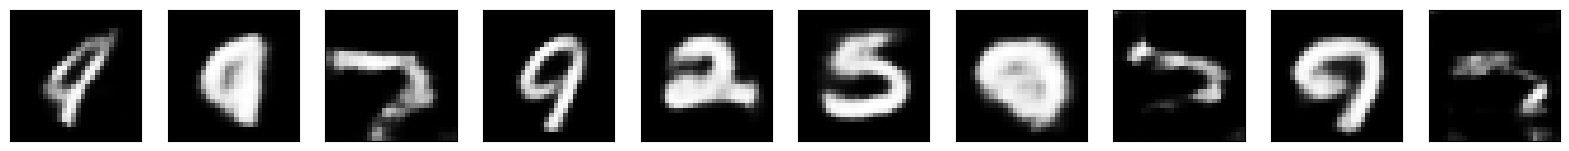

In [28]:
z_sample = K.random_normal((10,latent_dim))
generated = decoder.predict(z_sample)
plot(generated)